## Import packages

In [ ]:
import pickle 
import numpy as np
import os.path as osp

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from dataset_column_schema import DatasetSchemas 
from dataset_manager_optimized import DatasetManager

## Setup preprocessing

In [277]:
data_dir =  r'C:\Users\sahat\OneDrive - KU Leuven\Research\PPM&xAI\data'
# '/data/leuven/365/vsc36567/xAI-PPM/data/processed_benchmark_event_logs'

ds_name = 'bpic2017' 
ds_file_names = ['BPIC17_O_Accepted.csv'] #, 'BPIC17_O_Cancelled.csv', 'BPIC17_O_Refused.csv']
bpic17_column_schema = DatasetSchemas.bpic2017()

bucketing_method = 'single'
encoding_method = 'agg'
encoding_dict = {
            "laststate": ["static", "last"],
            "agg": ["static", "agg"],
            "index": ["static", "index"],
            "combined": ["static", "last", "agg"]
        }

In [278]:
encoding_args = bpic17_column_schema.get_encoder_args(fillna=True)

In [279]:
# Initialize a dataset manager

gap = 1
train_ratio = 0.8
random_state=22

dm = DatasetManager(ds_name, ds_column_schema=bpic17_column_schema) 
data = dm.read_dataset(osp.join(data_dir, ds_file_names[0]))


# Splitting the data into train and test set
train, test = dm.split_data_strict(data, train_ratio=train_ratio, split="temporal")
print("Shape of the train set: ", train.shape,
    "\nShape of the test set: ",  test.shape)
max_prefix_length = min(20, dm.get_pos_case_length_quantile(data, 0.90))
print(
    f"\nGenerating train and test prefixes with the max length {max_prefix_length}"
)

Shape of the train set:  (927785, 26) 
Shape of the test set:  (239791, 26)

Generating train and test prefixes with the max length 20


In [280]:
train_prefixes = dm.generate_prefix_data(train, min_length=1, max_length=max_prefix_length, gap=1)
test_prefixes = dm.generate_prefix_data(test, min_length=1, max_length=max_prefix_length, gap=1)

In [416]:
train.tail(50)

,ApplicationType,LoanGoal,RequestedAmount,Case ID,label,Activity,org:resource,Action,EventOrigin,lifecycle:transition,...,timesincelastevent,timesincecasestart,timesincemidnight,event_nr,month,weekday,hour,open_cases,time:timestamp,case_length
915925,New credit,Home improvement,15000.0,Application_379569745,deviant,O_Returned,User_112,statechange,Offer,complete,...,0.728633,18244.742700,701.0,24.0,10.0,1.0,11.0,2270.0,2016-10-18 11:41:56.586,25
931681,New credit,Home improvement,25000.0,Application_1303779114,deviant,O_Returned,User_107,statechange,Offer,complete,...,2.499183,11275.927967,702.0,23.0,10.0,1.0,11.0,2270.0,2016-10-18 11:42:41.435,28
915926,New credit,Home improvement,15000.0,Application_379569745,deviant,W_Validate application,User_112,Released,Workflow,suspend,...,0.914033,18245.656733,702.0,25.0,10.0,1.0,11.0,2270.0,2016-10-18 11:42:51.428,25
958469,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,O_Create Offer,User_60,Created,Offer,complete,...,3.861450,17.914600,703.0,7.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:11.824,14
958470,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,O_Created,User_60,statechange,Offer,complete,...,0.008933,17.923533,703.0,8.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:12.360,14
958471,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,O_Sent (mail and online),User_60,statechange,Offer,complete,...,0.112683,18.036217,703.0,9.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:19.121,14
958472,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,W_Complete application,User_60,Deleted,Workflow,ate_abort,...,0.000200,18.036417,703.0,10.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:19.133,14
958473,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,W_Call after offers,User_60,Created,Workflow,schedule,...,0.000100,18.036517,703.0,11.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:19.139,14
958474,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,W_Call after offers,User_60,Obtained,Workflow,start,...,0.000017,18.036533,703.0,12.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:19.140,14
958475,New credit,Existing loan takeover,0.0,Application_1498483020,deviant,A_Complete,User_60,statechange,Application,complete,...,0.000033,18.036567,703.0,13.0,10.0,1.0,11.0,2270.0,2016-10-18 11:43:19.142,14


In [281]:
train_y = np.asarray(dm.get_label_numeric(train_prefixes))
test_y = np.asarray(dm.get_label_numeric(test_prefixes))

print('Shape of the train prefixes and labels:', train_prefixes.shape, train_y.shape)
print('Shape of the test prefixes and labels:', test_prefixes.shape, test_y.shape)

Shape of the train prefixes and labels: (5144464, 29) (494892,)
Shape of the test prefixes and labels: (1303489, 29) (124815,)


# Preprocess the data

In [282]:
import pandas as pd
from sklearn.pipeline import FeatureUnion
from preprocessing.encoding import get_encoder

In [283]:
# Drop columns "Credit Score" and "org:resource"

train_prefixes = train_prefixes.drop(labels=['CreditScore', 'org:resource'], axis=1)
test_prefixes = test_prefixes.drop(labels=['CreditScore', 'org:resource'], axis=1)

In [284]:
encoding_args['dynamic_cat_cols'].remove('CreditScore')
encoding_args['dynamic_cat_cols'].remove('org:resource')

In [285]:
feature_combiner = FeatureUnion([(method, get_encoder(method, **encoding_args)) for method in encoding_dict[encoding_method]])

In [286]:
encoded_train_X = feature_combiner.fit_transform(train_prefixes)
encoded_test_X = feature_combiner.transform(test_prefixes)

In [287]:
feature_names = []
for name, transformer in feature_combiner.transformer_list:
    if hasattr(transformer, "get_feature_names"):
        for fname in transformer.get_feature_names():
            feature_names.append(f"{name}_{fname}")      


In [288]:
# Convert to dense if the output is a sparse matrix
X_train = pd.DataFrame(np.array(encoded_train_X).astype(np.float64), columns=feature_names)
X_test = pd.DataFrame(np.array(encoded_test_X).astype(np.float64), columns=feature_names)

# Train the model

In [289]:
alexanders_best_params = {'colsample_bytree': 0.916,
                        'learning_rate': 0.0318,
                        'max_depth': 16,
                        'min_child_weight': 2,
                        'subsample': 0.6015,
                        'n_estimators': 500,
                        'n_jobs': -1}

classifier = XGBClassifier(**alexanders_best_params)
classifier.fit(X_train, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.916, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0318, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [290]:
preds = classifier.predict_proba(X_test.astype(np.float64))

In [291]:
auc_score = roc_auc_score(test_y, preds[:, 1])
print('AUC score: ', auc_score)

AUC score:  0.8429446566809651


# Optimize the hyperparameters

In [375]:
def get_cv_generator(data, k_folds, min_prefix_length, max_prefix_length, gap):
    df_prefixes = []
    for train_chunk, test_chunk in dm.get_stratified_split_generator(data, n_splits=k_folds):
        df_prefixes.append(
            dm.generate_prefix_data(train_chunk, min_prefix_length, max_prefix_length, gap=gap))
    del data

    for cv_iter in range(k_folds):
        test_fold = df_prefixes[cv_iter]
        train_fold = pd.concat([df_prefixes[i] for i in range(k_folds) if i != cv_iter], axis=0)
        yield train_fold, test_fold

In [376]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


def create_objective(data, k_folds=3, min_prefix_length=1, max_prefix_length=20, gap=1):
# Define the objective function
    def objective(params):
        # Convert to types expected by XGBoost
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])

        auc_scores = []
        cv_folds_generator = get_cv_generator(data, k_folds, min_prefix_length, max_prefix_length, gap)
        for cv_iter, (train_prefixes, test_prefixes) in enumerate(cv_folds_generator):
            y_train = dm.get_label_numeric(train_prefixes)
            X_train = train_prefixes.drop(columns=["label"])

            y_test = dm.get_label_numeric(test_prefixes)
            X_test = test_prefixes.drop(columns=["label"])
            encoder = FeatureUnion([(method, get_encoder(method, **encoding_args)) for method in encoding_dict[encoding_method]])
            encoded_train_X = encoder.fit_transform(X_train)
            encoded_test_X = encoder.transform(X_test)
            # print('data is encoded')
            
            clf = XGBClassifier(
                objective='binary:logistic',
                n_jobs=-1,
                **params,
            )
            clf.fit(encoded_train_X, y_train)
            print(f'model is fitted on the fold {cv_iter}.')
            preds = clf.predict_proba(encoded_test_X)[:, 1]

            auc = roc_auc_score(y_test, preds)
            auc_scores.append(auc)

        mean_auc = np.mean(auc_scores)
        # We minimize, so return the negative score
        return {'loss': -mean_auc, 'status': STATUS_OK}
    return objective


In [75]:

# Define hyperparameter search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

# Run the optimization
trials = Trials()

best = fmin(
    fn=create_objective(data, k_folds=3),
    space=space,
    algo=tpe.suggest,
    max_evals=3,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Best hyperparameters:", best)

model is fitted on the fold 0.                       
model is fitted on the fold 1.                       
model is fitted on the fold 2.                       
model is fitted on the fold 0.                                                   
model is fitted on the fold 1.                                                   
model is fitted on the fold 2.                                                   
model is fitted on the fold 0.                                                   
model is fitted on the fold 1.                                                   
model is fitted on the fold 2.                                                   
100%|██████████| 3/3 [15:06<00:00, 302.33s/trial, best loss: -0.9080159522699432]
Best hyperparameters: {'colsample_bytree': 0.8102773654663284, 'gamma': 4.455746297888614, 'learning_rate': 0.2487952837287915, 'max_depth': 7.0, 'n_estimators': 90.0, 'reg_alpha': 0.6176608512730031, 'reg_lambda': 0.07366102545052411, 'subsample': 0.6587851149140

In [ ]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators']) 

best_classifier = XGBClassifier(**best)
best_classifier.fit(X_train, train_y)

preds = best_classifier.predict_proba(X_test)
auc_score = roc_auc_score(test_y, preds[:, 1])
print('AUC score:', auc_score)

AUC score: 0.8375777768011943


In [ ]:
alexanders_best_params = {'colsample_bytree': 0.916,
                        'learning_rate': 0.0318,
                        'max_depth': 16,
                        'min_child_weight': 2,
                        'subsample': 0.6015,
                        'n_estimators': 500,
                        'n_jobs': -1}

classifier = XGBClassifier(**alexanders_best_params)
classifier.fit(X_train, train_y)

In [22]:
preds = classifier.predict_proba(X_test.astype(np.float64))
auc_score = roc_auc_score(test_y, preds[:, 1])
print('AUC score:', auc_score)

AUC score: 0.8433990430703413


# Explaining the model 

**Questions for experiments:**
1. Do results with the "interventional" approach given a bachground dataset differ from "tree_path_dependent"?
2. Can a background dataset be constructed that it forms a cohort of similar instances?
3. Will this approach differ from the Cohort Shapley values estimations?  

In [331]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt 

import shap 
from alibi.explainers import TreeShap

# print the JS visualization code to the notebook
shap.initjs()

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'


SHAP values for local explanations of certain cases for BPIC2017
1. Generate correlation matrix for checking correlated features
2. Compute SHAP values 
3. Analyze obtained results

Sampling encoded cases of various lengths from the test set

In [332]:
for col in X_test.columns:
    print(col)

static_RequestedAmount
static_ApplicationType_Limit raise
static_ApplicationType_New credit
static_LoanGoal_Car
static_LoanGoal_Caravan / Camper
static_LoanGoal_Existing loan takeover
static_LoanGoal_Extra spending limit
static_LoanGoal_Home improvement
static_LoanGoal_Motorcycle
static_LoanGoal_Not speficied
static_LoanGoal_Other, see explanation
static_LoanGoal_Remaining debt home
static_LoanGoal_Unknown
static_LoanGoal_other
agg_Activity_A_Accepted
agg_Activity_A_Cancelled
agg_Activity_A_Complete
agg_Activity_A_Concept
agg_Activity_A_Create Application
agg_Activity_A_Denied
agg_Activity_A_Incomplete
agg_Activity_A_Pending
agg_Activity_A_Submitted
agg_Activity_A_Validating
agg_Activity_O_Accepted
agg_Activity_O_Cancelled
agg_Activity_O_Create Offer
agg_Activity_O_Created
agg_Activity_O_Refused
agg_Activity_O_Returned
agg_Activity_O_Sent (mail and online)
agg_Activity_O_Sent (online only)
agg_Activity_W_Assess potential fraud
agg_Activity_W_Call after offers
agg_Activity_W_Call incomp

In [401]:
def sample_to_explain(X_test, encoding_method, min_rows_num=30):
    sampled_indices = []

    for prefix_length in range(1, 21):
        subset = X_test[X_test[f'{encoding_method}_event_nr_max'] == prefix_length]
        
        # You can adjust the size (e.g., 1% or 100 samples per prefix group)
        n = min(min_rows_num, len(subset))  # cap or proportion
        sampled_subset = subset.sample(n=n, random_state=42)
        
        sampled_indices.extend(sampled_subset.index)
        
    return X_test.loc[sampled_indices].reset_index(drop=True)

In [386]:
X_test_sampled = sample_to_explain(X_test, encoding_method='agg')
X_test_sampled.head()

,static_RequestedAmount,static_ApplicationType_Limit raise,static_ApplicationType_New credit,static_LoanGoal_Car,static_LoanGoal_Caravan / Camper,static_LoanGoal_Existing loan takeover,static_LoanGoal_Extra spending limit,static_LoanGoal_Home improvement,static_LoanGoal_Motorcycle,static_LoanGoal_Not speficied,...,agg_hour_mean,agg_hour_max,agg_hour_min,agg_hour_sum,agg_hour_std,agg_open_cases_mean,agg_open_cases_max,agg_open_cases_min,agg_open_cases_sum,agg_open_cases_std
0,5000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,0.0,1823.0,1823.0,1823.0,1823.0,0.0
1,5000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,19.0,19.0,19.0,19.0,0.0,1911.0,1911.0,1911.0,1911.0,0.0
2,20000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,11.0,11.0,11.0,11.0,0.0,1945.0,1945.0,1945.0,1945.0,0.0
3,31500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,9.0,9.0,9.0,0.0,1946.0,1946.0,1946.0,1946.0,0.0
4,30000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,10.0,10.0,0.0,2143.0,2143.0,2143.0,2143.0,0.0


## Path-dependent SHAP values

In [396]:
# shap package
# explainer = shap.TreeExplainer(classifier)
# shap_values = explainer(X_test.iloc[0:100])

# alibi package
path_dependent_explainer = TreeShap(classifier, model_output='raw', task='classification')
path_dependent_explainer.fit(); # does not require background_data

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


In [397]:
path_dependent_explanation = path_dependent_explainer.explain(X_test_sampled)
path_dependent_shap_values = path_dependent_explanation.shap_values[0]

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3974884906.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(path_dependent_shap_values, X_test_sampled, X_test_sampled.columns, plot_size=(10, 7))


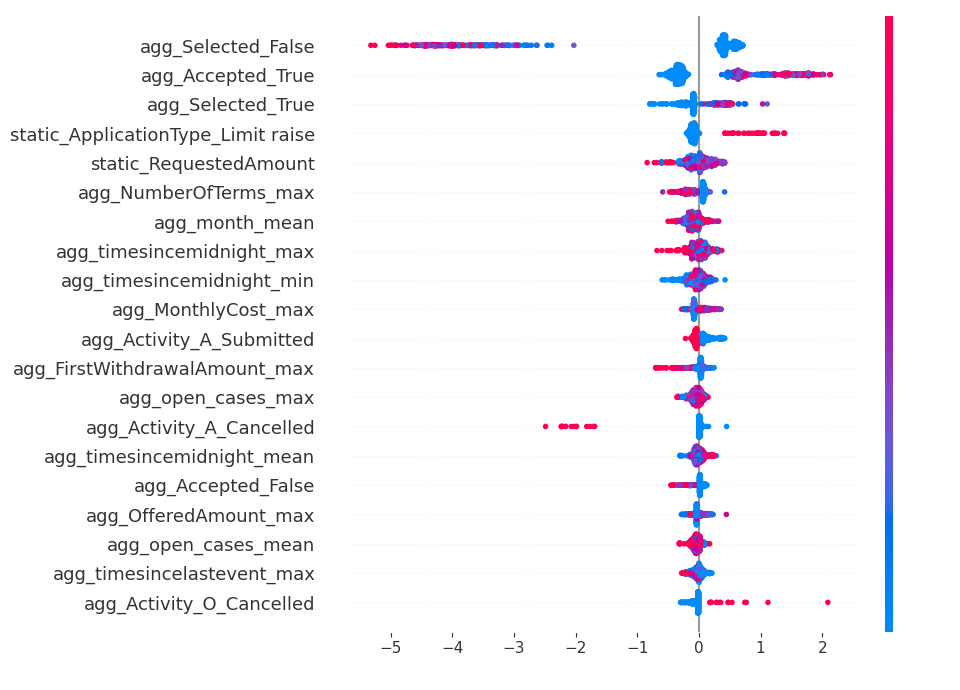

In [389]:
shap.summary_plot(path_dependent_shap_values, X_test_sampled, X_test_sampled.columns, plot_size=(10, 7))

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3943686392.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(path_dependent_shap_values, X_test_sampled, feature_names, plot_type='bar')


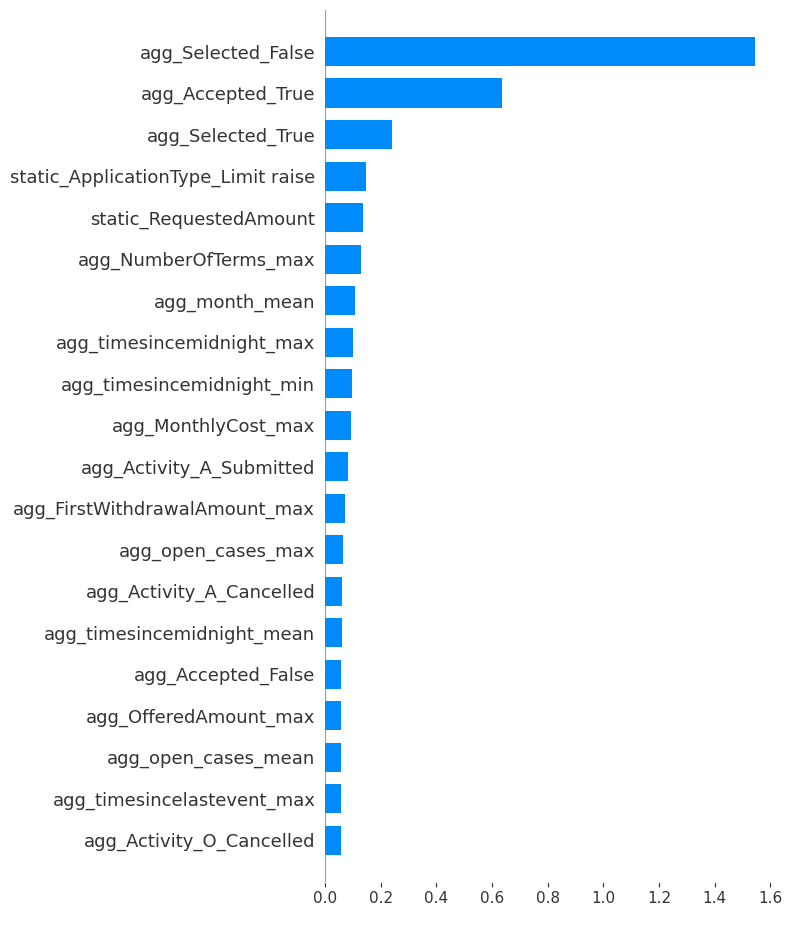

In [398]:
shap.summary_plot(path_dependent_shap_values, X_test_sampled, feature_names, plot_type='bar')

Extracting encoded feature names and their indices of the categorical variables

In [334]:
X_test_sampled.columns = list(map(lambda x: x.split('_', maxsplit=1)[1], list(X_test_sampled.columns)))

In [335]:
cat_cols = encoding_args['static_cat_cols']

cat_feature_indices = {}
cat_feature_names = {}

enc_cols = pd.Series(X_test_sampled.columns)

for cat_col in cat_cols:
    matches = enc_cols[enc_cols.str.startswith(cat_col)]
    cat_feature_names[cat_col] = matches.tolist()
    cat_feature_indices[cat_col] = matches.index[0] if not matches.empty else None

In [336]:
cat_vars_start_idx = list(cat_feature_indices.values())
cat_vars_enc_dim = list(map(len, list(cat_feature_names.values())))
print('Starting indices of the categorical features among encoded ones:', cat_vars_start_idx)
print('Cardinality of each categorical feature after encoding:', cat_vars_enc_dim)

Starting indices of the categorical features among encoded ones: [1, 3]
Cardinality of each categorical feature after encoding: [2, 11]


In [ ]:
"""total_enc_cat_levels = []
for inner_list in list(cat_feature_names.values()):
    total_enc_cat_levels.extend(inner_list)
print('Categorical features len:', len(total_enc_cat_levels))

num_cols = encoding_args['static_num_cols'] + encoding_args['dynamic_num_cols']

num_feature_names = {}

for num_col in num_cols:
    matches = enc_cols[enc_cols.str.contains(num_col)]
    num_feature_names[num_col] = matches.tolist()

num_vars_enc_dim = list(map(len, list(num_feature_names.values())))
print('Numerical features len:', num_vars_enc_dim, '->',  sum(num_vars_enc_dim))"""

In [337]:
tree_explainer = TreeShap(classifier, model_output='raw', task='classification')
tree_explainer.fit()
pd_explanations = tree_explainer.explain(X_test_sampled, 
                                        summarise_result=True,
                                        cat_vars_start_idx=cat_vars_start_idx,
                                        cat_vars_enc_dim=cat_vars_enc_dim)

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


In [338]:
pd_shap_values = pd_explanations.shap_values[0]

Aggregate features of the sample to be explained, since the categorical variables were grouped

In [339]:
counter = 0
ind = 0

cat_feature_indices_reversed = {v: k for k, v in cat_feature_indices.items()}
num_and_agg_cat_names = []

while ind < enc_cols.shape[0]:
    if ind in cat_feature_indices.values():
        # print('ind before', ind)
        # print('counter before', counter)
        indices = list(range(ind, ind+cat_vars_enc_dim[counter]))
        enc_cat_cols = X_test_sampled.columns[indices]
        # print(enc_cat_cols)
        cat_col = cat_feature_indices_reversed[ind]
        num_and_agg_cat_names.append(cat_col)
        ind += cat_vars_enc_dim[counter] 
        counter += 1
        # print('ind after', ind)
        # print('counter after', counter)
    else:
        num_and_agg_cat_names.append(enc_cols[ind])
        ind += 1

In [340]:
X_test_sampled_agg = pd.DataFrame()

for col in num_and_agg_cat_names:
    if col in cat_feature_names.keys():
        enc_cat_cols = cat_feature_names[col]
        dummy_data = X_test_sampled.loc[:, enc_cat_cols]
        dummy_data = dummy_data.astype(np.int8)
        X_test_sampled_agg[col] = pd.from_dummies(dummy_data)
    else:
        X_test_sampled_agg[col] = X_test_sampled.loc[:, [col]]

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3895636598.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_sampled_agg[col] = X_test_sampled.loc[:, [col]]
C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3895636598.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_sampled_agg[col] = X_test_sampled.loc[:, [col]]
C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3895636598.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\2323490021.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(pd_shap_values, X_test_sampled_agg, num_and_agg_cat_names, plot_size=(10, 7), show=False)
C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\2323490021.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


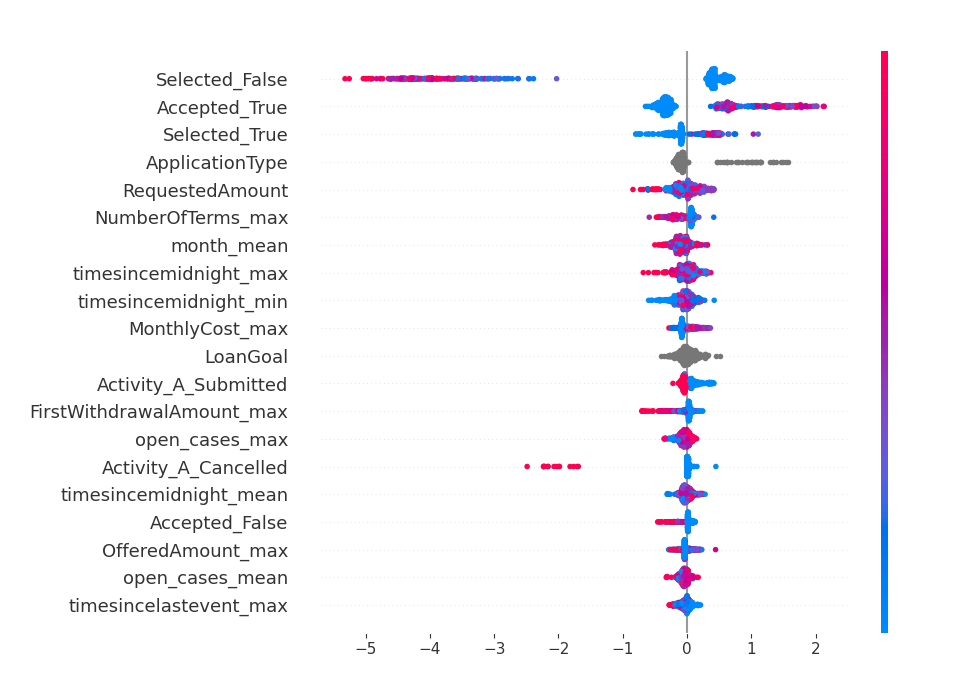

In [ ]:
shap.summary_plot(pd_shap_values, X_test_sampled_agg, num_and_agg_cat_names, plot_size=(10, 7), show=False)

"""# Get current Axes and Figure
ax = plt.gca()
fig = plt.gcf()

# Now set your labels
ax.set_xlabel("SHAP value (impact on model output)")
ax.set_ylabel("Feature name")
fig.suptitle("SHAP Summary Plot (Dot)", fontsize=14)

plt.tight_layout()
plt.show()"""

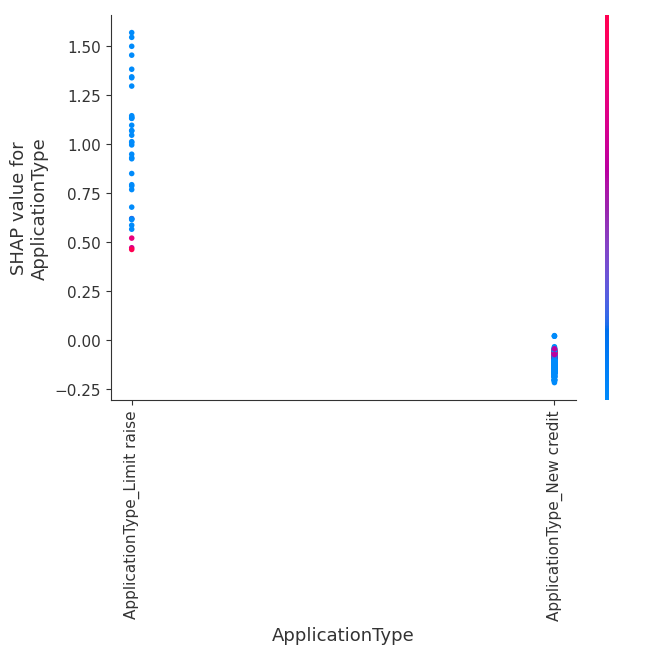

In [348]:
shap.dependence_plot('ApplicationType', pd_shap_values, X_test_sampled_agg, feature_names=num_and_agg_cat_names)

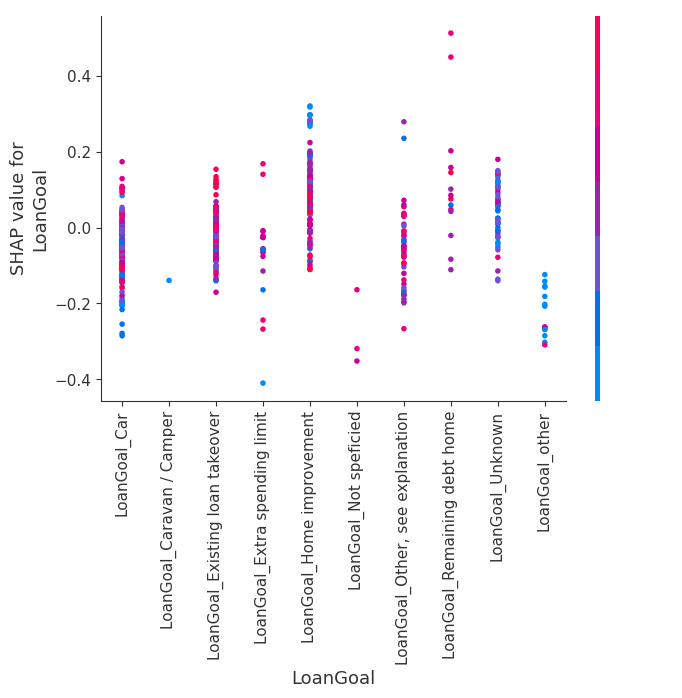

In [349]:
shap.dependence_plot('LoanGoal', pd_shap_values, X_test_sampled_agg, feature_names=num_and_agg_cat_names)

### Exclude features "Selected" and "Accepted"

In [370]:
enc_train_cols = X_train.columns
selected_cols = enc_train_cols[enc_train_cols.str.startswith('agg_Selected')]
accepted_cols = enc_train_cols[enc_train_cols.str.startswith('agg_Accepted')]

X_train2 = X_train.drop(selected_cols.to_list() + accepted_cols.to_list(), axis=1)
X_test2 = X_test.drop(selected_cols.to_list() + accepted_cols.to_list(), axis=1)

In [381]:
# alexanders_best_params = {'colsample_bytree': 0.916,
#                         # 'learning_rate': 0.0318,
#                         'max_depth': 16,
#                         'min_child_weight': 2,
#                         'subsample': 0.8,
#                         'n_estimators': 500,
#                         'n_jobs': -1}

classifier2 = XGBClassifier()
classifier2.fit(X_train2, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [382]:
preds2 = classifier2.predict_proba(X_test2)

In [383]:
auc_score = roc_auc_score(test_y, preds2[:, 1])
print('AUC score: ', auc_score)

AUC score:  0.6836031962152462


In [390]:
X_test_sampled2 = sample_to_explain(X_test2, encoding_method='agg')

In [392]:
explainer2 = TreeShap(classifier2, model_output='raw', task='classification')
explainer2.fit(); # does not require background_data
explanation2 = explainer2.explain(X_test_sampled2)
shap_values2 = explanation2.shap_values[0]

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\2062505834.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_test_sampled2, X_test_sampled2.columns, plot_size=(10, 7))


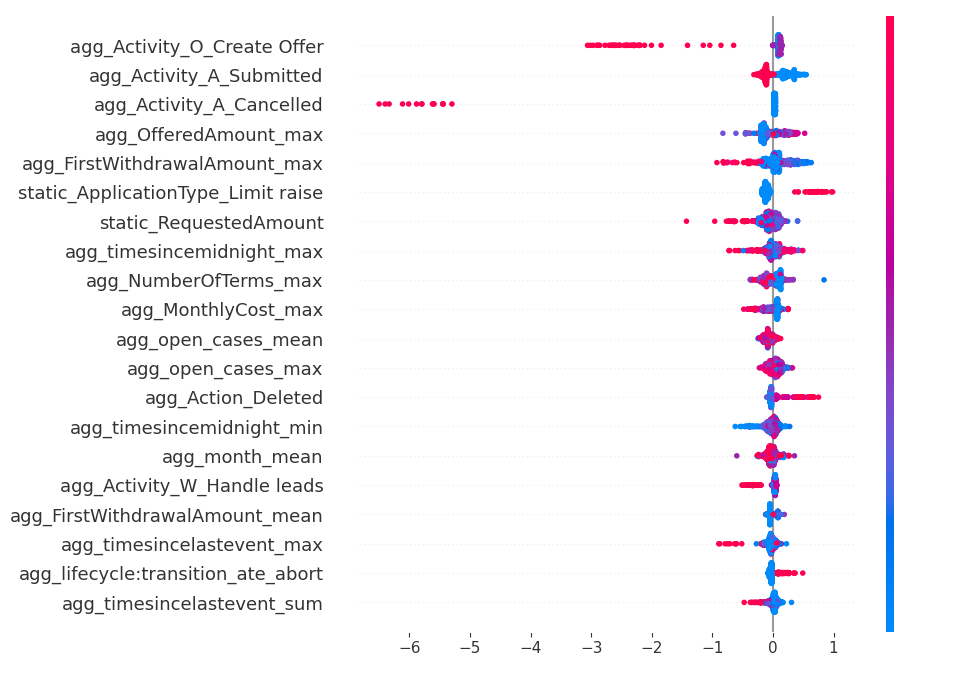

In [394]:
shap.summary_plot(shap_values2, X_test_sampled2, X_test_sampled2.columns, plot_size=(10, 7))

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\3366228769.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_test_sampled2, X_test_sampled2.columns, plot_size=(10, 7), plot_type='bar')


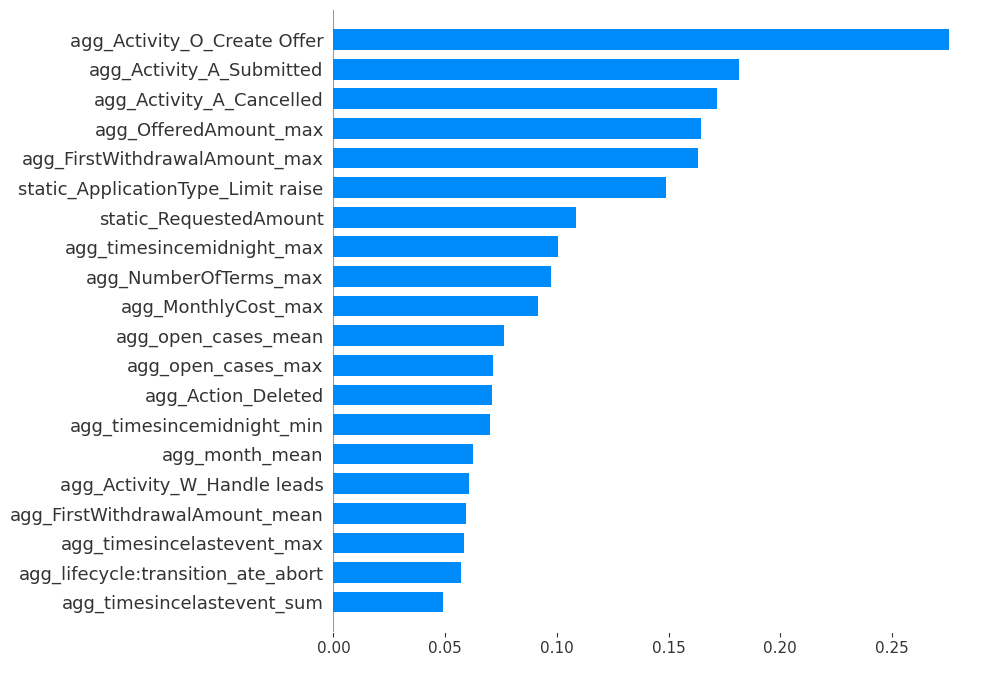

In [399]:
shap.summary_plot(shap_values2, X_test_sampled2, X_test_sampled2.columns, plot_size=(10, 7), plot_type='bar')

## Interventional SHAP values

In [400]:
from alibi.utils import gen_category_map 

In [403]:
background_data = sample_to_explain(X_train, encoding_method=encoding_method, min_rows_num=10)

In [404]:
tree_explainer_interventional = TreeShap(classifier, model_output='raw', task='classification')
tree_explainer_interventional.fit(background_data=background_data)

The upstream implementation of interventional TreeShap supports only up to 100 samples in the background dataset. A larger background dataset will be sampled with replacement to 100 instances.
Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


TreeShap(meta={
  'name': 'TreeShap',
  'type': ['whitebox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'model_output': 'raw',
              'summarise_background': False,
              'summarise_result': None,
              'approximate': None,
              'interactions': None,
              'explain_loss': None,
              'algorithm': 'interventional',
              'kwargs': {}}
            ,
  'version': '0.9.6'}
)

In [405]:
explanation = tree_explainer_interventional.explain(X_test_sampled)

100%|===================| 599/600 [02:56<00:00]        

In [ ]:
with open('output/shap_interv_xgboost_bpic2017.pkl', 'wb') as f:
        pickle.dump(explanation.shap_values[0], f)

In [407]:
interventional_shap_values = explanation.shap_values[0]

C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\2448825762.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(interventional_shap_values, X_test_sampled, X_test_sampled.columns, plot_type='bar')


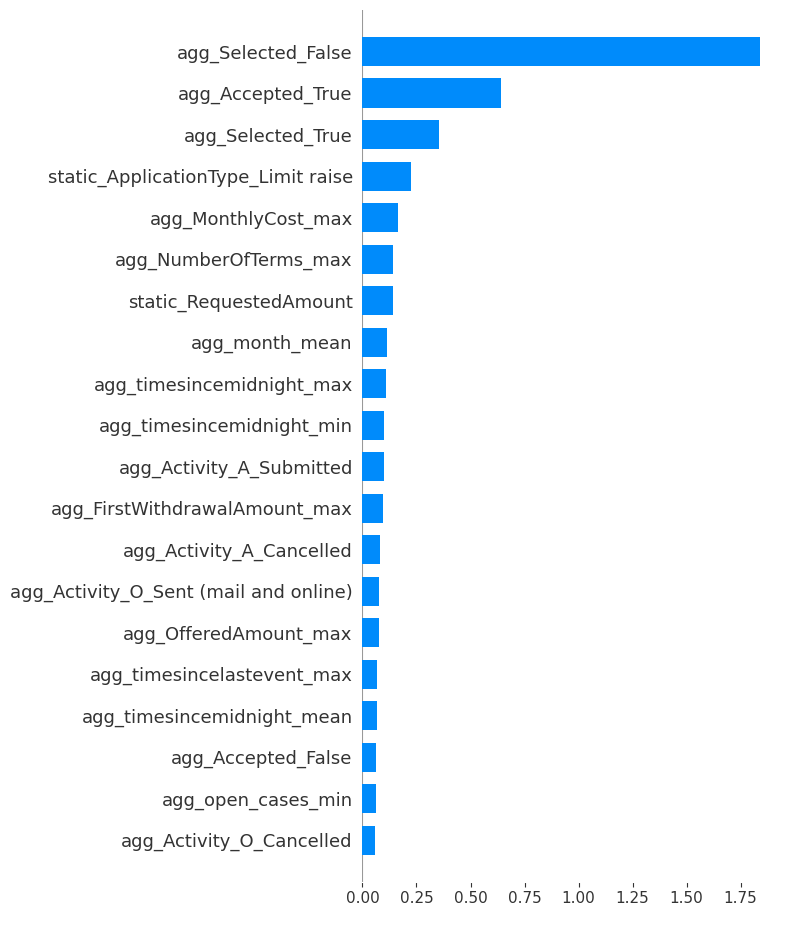

In [408]:
shap.summary_plot(interventional_shap_values, X_test_sampled, X_test_sampled.columns, plot_type='bar')


C:\Users\sahat\AppData\Local\Temp\ipykernel_29344\135516586.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(interventional_shap_values, X_test_sampled, X_test_sampled.columns)


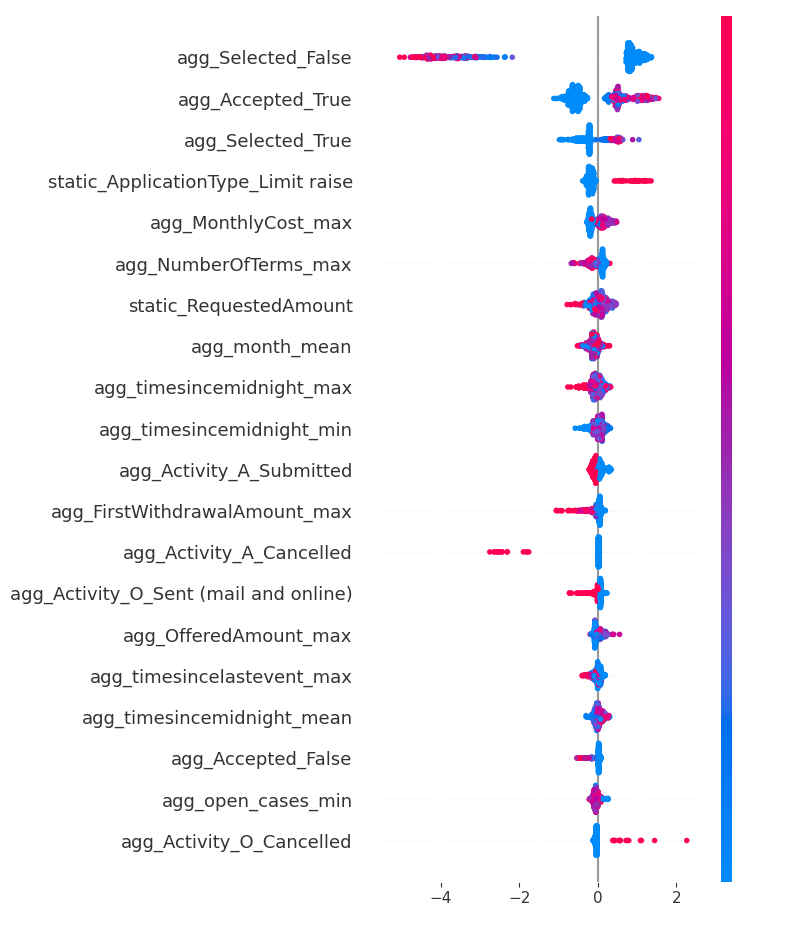

In [409]:
shap.summary_plot(interventional_shap_values, X_test_sampled, X_test_sampled.columns)

## Cohort Shapley 

1. Understand how to make binning and to what numerical features apply it
2. Choose a similarity function
